In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import seaborn as sns
import configs
import os
import torch
from scipy.stats import pearsonr
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR
from sklearn.decomposition import PCA
import deer.controllers as bc 
import yaml
from scipy.stats import pearsonr
from deer.policies import EpsilonGreedyPolicy, FixedFigure8Policy  

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from deer.environments.Foraging import MyEnv as Env

In [3]:
import torch
torch.cuda.is_available = lambda : False

# Parameters

In [4]:
engram_dir = '/Volumes/aronov-locker/Ching/rl/'
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'
internal_dim = 10
generic_exp_name = 'foraging_w_SR'
exp_name = f'{generic_exp_name}_dm_dim{internal_dim}'
latents_dir = f'{engram_dir}latents/{exp_name}/'
nnets_dir = f'{engram_dir}nnets/{exp_name}/'
pickle_dir = f'{engram_dir}pickles/{exp_name}/'

# Helper functions

In [5]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

# Run test experiments

In [6]:
from sklearn.decomposition import KernelPCA

In [13]:
model = []
gini_coeff = []
auc = []
entro = []
components = []
for model_name in os.listdir(nnets_dir):
    print(model_name)
    if 'foraging' not in model_name: continue
    if 'mb' in model_name:
        fname = f'{generic_exp_name}_mb'
        model.append('mb')
    elif 'mf' in model_name:
        fname = f'{generic_exp_name}_mf'
        model.append('mf')
    elif 'entro' in model_name:
        fname = f'{generic_exp_name}_entro'
        model.append('entro')
    elif 'sr' in model_name:
        fname = f'{generic_exp_name}_sr'
        model.append('diffusive')
    else:
        continue
    with open(f'{engram_dir}params/{fname}.yaml', 'r') as f:
        parameters = yaml.safe_load(f)
    parameters['fname'] = f'{exp_name}/{model_name}'
    parameters['internal_dim'] = internal_dim
    env = Env(                                                                     
        rng=np.random.RandomState(),
        give_rewards=parameters['foraging_give_rewards'],                           
        higher_dim_obs=parameters['higher_dim_obs'],                               
        size_maze=parameters['size_maze'])
    rng = np.random.RandomState()
    learning_algo = CRAR(                                                          
        env, parameters['freeze_interval'], parameters['batch_size'], rng,         
        internal_dim=parameters['internal_dim'], lr=parameters['learning_rate'],
        nn_yaml=parameters['nn_yaml'], yaml_mods=parameters['yaml_mods'],          
        double_Q=True, loss_weights=parameters['loss_weights'],                    
        encoder_type=parameters['encoder_type']
        )   
    train_policy = EpsilonGreedyPolicy(                                     
        learning_algo, env.nActions(), rng, epsilon=1.)             
    test_policy = EpsilonGreedyPolicy(                                      
        learning_algo, env.nActions(), rng, 0.)  
    agent = NeuralAgent(                                                        
        env, learning_algo, parameters['replay_memory_size'], 1,                
        parameters['batch_size'], rng, save_dir=engram_dir,                     
        train_policy=train_policy, test_policy=test_policy)
    agent.attach(bc.LearningRateController(                                     
        initial_learning_rate=parameters['learning_rate'],                      
        learning_rate_decay=parameters['learning_rate_decay'],                  
        periodicity=1))                                                         
    agent.attach(bc.TrainerController(                                          
        evaluate_on='action',  periodicity=parameters['update_frequency'],      
        show_episode_avg_V_value=True, show_avg_Bellman_residual=True))         
    best_controller = bc.FindBestController(                                    
        validationID=Env.VALIDATION_MODE, testID=None, unique_fname=fname)      
    agent.attach(best_controller)                                               
    agent.attach(bc.InterleavedTestEpochController(                             
        id=Env.VALIDATION_MODE, epoch_length=parameters['steps_per_test'],      
        periodicity=1, show_score=True, summarize_every=10, unique_fname=fname))
    try:
        agent.setNetwork(parameters['fname'] + '/fname', nEpoch=51)
    except:
        print(f'Skipping {model_name}')

    agent._in_episode = True
    agent._mode = 0 # Testing mode with plan_depth=0
    initState = env.reset(agent._mode)
    inputDims = env.inputDimensions()
    for i in range(len(inputDims)):
        if inputDims[i][0] > 1:
            agent._state[i][1:] = initState[i][1:]
    agent._Vs_on_last_episode = []
    is_terminal = False
    reward = 0
    
    # Get latents
    all_possib_inp = [] 
    quadrant_labels = [] # which quadrant
    maze_x = []
    maze_y = []
    env.create_map()
    for y_a in range(env._size_maze):
        for x_a in range(env._size_maze):                
            if env._map[x_a, y_a] != 1:
                if env._higher_dim_obs:
                    all_possib_inp.append(env.get_higher_dim_obs([x_a, y_a]))
                else:
                    all_possib_inp.append(env.get_low_dim_obs([x_a, y_a]))
                quadrant_label = 0 if x_a < env._size_maze//2 else 2
                quadrant_label += (0 if y_a < env._size_maze//2 else 1)
                quadrant_labels.append(quadrant_label)
                maze_x.append(x_a)
                maze_y.append(y_a)
    with torch.no_grad():
        latents = learning_algo.crar.encoder(
            torch.tensor(all_possib_inp).float()).cpu().numpy()
    if latents.ndim == 4: # data_format='channels_last' -> 'channels_first'
        latents = np.transpose(latents, (0, 3, 1, 2))
        
    pca = PCA(n_components=0.9) #KernelPCA(kernel='poly', remove_zero_eig=True)
    reduced_latents = pca.fit_transform(latents)
    var_ratio = pca.explained_variance_ratio_ #eigenvalues_
    var_gini = gini(var_ratio)
    var_curve = np.cumsum(var_ratio)
    var_auc = np.trapz(var_curve, dx=1/var_curve.size)
    n_components = var_ratio.size
    var_entro = -np.sum(var_ratio * np.log(var_ratio)) / np.log(2) #bits
    
    gini_coeff.append(var_gini)
    auc.append(var_auc)
    entro.append(var_entro)
    components.append(n_components)

foraging_w_SR_entro_19
foraging_w_SR_entro_6
foraging_w_SR_mb_11
foraging_w_SR_mf_10
foraging_w_SR_sr_8
foraging_w_SR_mf_22
foraging_w_SR_sr_10
foraging_w_SR_entro_4
foraging_w_SR_sr_7
foraging_w_SR_sr_33
foraging_w_SR_sr_0
foraging_w_SR_sr_31
foraging_w_SR_sr_15
foraging_w_SR_entro_5
foraging_w_SR_sr_6
foraging_w_SR_mf_34
foraging_w_SR_mb_16
foraging_w_SR_sr_35
foraging_w_SR_mf_6
foraging_w_SR_sr_21
foraging_w_SR_mb_31
foraging_w_SR_entro_22
foraging_w_SR_mf_30
foraging_w_SR_entro_27
foraging_w_SR_sr_19
foraging_w_SR_mb_19
foraging_w_SR_sr_5
foraging_w_SR_mb_15
foraging_w_SR_sr_22
foraging_w_SR_mf_23
foraging_w_SR_entro_3
foraging_w_SR_entro_8
foraging_w_SR_mb_33
foraging_w_SR_mb_25
foraging_w_SR_sr_30
foraging_w_SR_entro_32
foraging_w_SR_mb_3
foraging_w_SR_entro_11
foraging_w_SR_entro_7
foraging_w_SR_entro_30
foraging_w_SR_entro_20
foraging_w_SR_mb_5
foraging_w_SR_sr_13
foraging_w_SR_mf_3
foraging_w_SR_entro_25
foraging_w_SR_mb_26
foraging_w_SR_mf_0
foraging_w_SR_entro_26
foraging_w_

In [14]:
df = pd.DataFrame({
    'model': np.array(model),
    'gini_coeff': np.array(gini_coeff),
    'auc': np.array(auc),
    'entropy': np.array(entro),
    'components': np.array(components)
    })

<AxesSubplot: xlabel='model', ylabel='gini_coeff'>

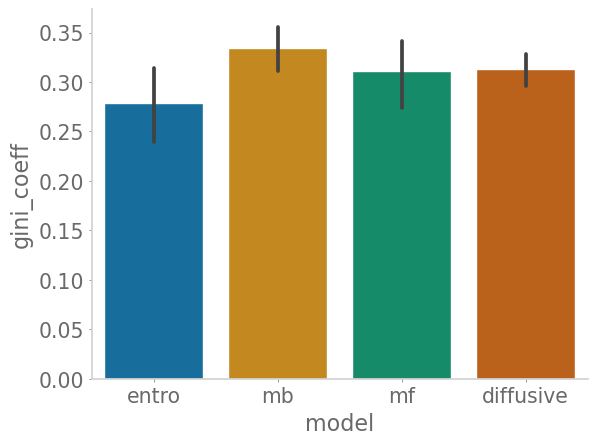

In [15]:
sns.barplot(x='model', y='gini_coeff', data=df)

<AxesSubplot: xlabel='model', ylabel='auc'>

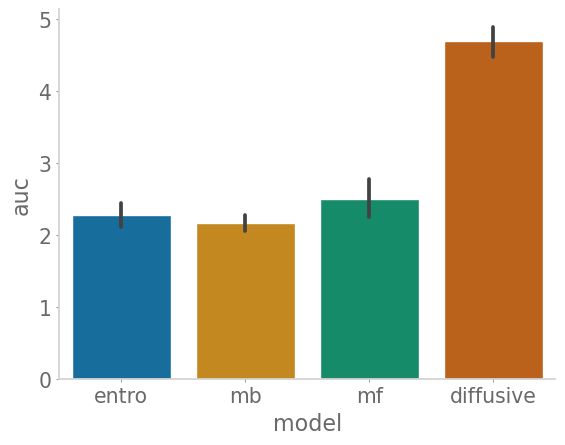

In [16]:
sns.barplot(x='model', y='auc', data=df)

<AxesSubplot: xlabel='model', ylabel='entropy'>

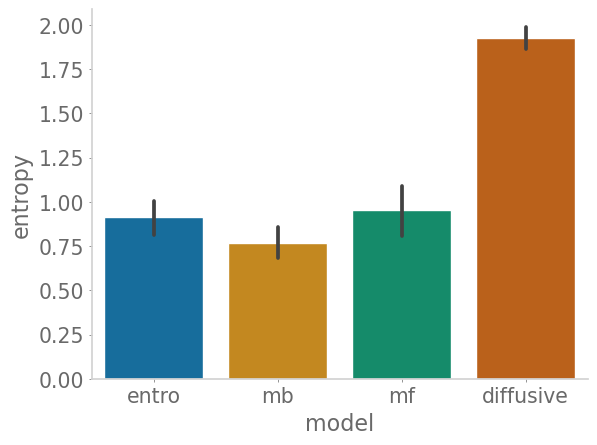

In [17]:
sns.barplot(x='model', y='entropy', data=df)